## Section 1: Data Preparation and cleaning 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import dash
from dash import dcc, html, Input, Output
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/ongei001/healthcare-disease-dashboard/main/african_healthcare_data.csv"
df_raw = pd.read_csv(url)
df_raw.head()

,Country,Region,Vaccination_Rate,Malaria_Prevalence,HIV_Prevalence,Healthcare_Facilities,Access_to_Water,Access_to_Sanitation
0,Algeria,North Africa,42.831536,15.087879,26.824910,519,87.325915,52.722140
1,Angola,Southern Africa,77.783157,24.653543,2.243721,744,78.515782,50.662117
2,Benin,West Africa,71.217525,10.403721,5.182927,183,84.123825,50.621811
3,Botswana,Southern Africa,87.749450,22.900074,7.780997,614,79.193866,59.217777
4,Burkina Faso,West Africa,88.505142,16.817282,4.275043,121,47.098470,78.838616


In [3]:
print("Initial shape:", df_raw.shape)
df_raw.info()
df_raw.describe(include='all')
df_raw.isnull().sum()


Initial shape: (54, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                54 non-null     object 
 1   Region                 54 non-null     object 
 2   Vaccination_Rate       54 non-null     float64
 3   Malaria_Prevalence     54 non-null     float64
 4   HIV_Prevalence         54 non-null     float64
 5   Healthcare_Facilities  54 non-null     int64  
 6   Access_to_Water        54 non-null     float64
 7   Access_to_Sanitation   54 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.5+ KB


Country                  0
Region                   0
Vaccination_Rate         0
Malaria_Prevalence       0
HIV_Prevalence           0
Healthcare_Facilities    0
Access_to_Water          0
Access_to_Sanitation     0
dtype: int64

### handel missing values 
### counting missing values per column in detail

In [4]:
# Create a detailed analysis of missing values
print("=" * 60)
print("DETAILED MISSING VALUES ANALYSIS")
print("=" * 60)

# Create a dataframe to show missing value information
missing_info = pd.DataFrame({
    'Column_Name': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum().values,
    'Missing_Percentage': (df_raw.isnull().sum().values / len(df_raw)) * 100,
    'Data_Type': df_raw.dtypes.values
})

# Sort by missing percentage (highest first)
missing_info = missing_info.sort_values('Missing_Percentage', ascending=False)

print("Missing values summary (sorted by percentage):")
print(missing_info)

# Identify columns with high missing values (>30%)
high_missing = missing_info[missing_info['Missing_Percentage'] > 30]
print(f"\n Columns with more than 30% missing data:")
if len(high_missing) > 0:
    for _, row in high_missing.iterrows():
        print(f"   • {row['Column_Name']}: {row['Missing_Percentage']:.1f}% missing")
else:
    print("   • No columns have more than 30% missing data ")

DETAILED MISSING VALUES ANALYSIS
Missing values summary (sorted by percentage):
             Column_Name  Missing_Count  Missing_Percentage Data_Type
0                Country              0                 0.0    object
1                 Region              0                 0.0    object
2       Vaccination_Rate              0                 0.0   float64
3     Malaria_Prevalence              0                 0.0   float64
4         HIV_Prevalence              0                 0.0   float64
5  Healthcare_Facilities              0                 0.0     int64
6        Access_to_Water              0                 0.0   float64
7   Access_to_Sanitation              0                 0.0   float64

 Columns with more than 30% missing data:
   • No columns have more than 30% missing data 


In [5]:
# Check for inconsistent data formats in each column
print("=" * 60)
print("DATA FORMAT CONSISTENCY CHECK")
print("=" * 60)

# Check text columns for inconsistencies
text_columns = df_raw.select_dtypes(include=['object']).columns

for column in text_columns:
    print(f"\n Analyzing column: {column}")
    print(f"   • Total unique values: {df_raw[column].nunique()}")
    
    # Check for leading/trailing spaces
    if df_raw[column].notna().any():
        has_spaces = df_raw[column].dropna().str.strip().equals(df_raw[column].dropna())
        if not has_spaces:
            print(f"    Has leading/trailing spaces")
        else:
            print(f"    No leading/trailing spaces")
        
        # Check for mixed case
        sample_values = df_raw[column].dropna().head(10).tolist()
        print(f"   • Sample values: {sample_values}")
        
        # Check for special characters or numbers in text fields
        if column.lower() in ['country', 'nation', 'region']:
            numeric_in_text = df_raw[column].dropna().str.contains(r'\d').sum()
            if numeric_in_text > 0:
                print(f"    {numeric_in_text} entries contain numbers")
            else:
                print(f"    No numeric characters in text")

DATA FORMAT CONSISTENCY CHECK

 Analyzing column: Country
   • Total unique values: 54
    No leading/trailing spaces
   • Sample values: ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad']
    No numeric characters in text

 Analyzing column: Region
   • Total unique values: 5
    No leading/trailing spaces
   • Sample values: ['North Africa', 'Southern Africa', 'West Africa', 'Southern Africa', 'West Africa', 'East Africa', 'West Africa', 'Central Africa', 'Central Africa', 'Central Africa']
    No numeric characters in text


In [6]:
# Lowercase, replace spaces and special chars
df_raw.columns = (
    df_raw.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '_', regex=True)
    .str.replace(r'[()%]', '', regex=True)
)

df_raw.head()


,country,region,vaccination_rate,malaria_prevalence,hiv_prevalence,healthcare_facilities,access_to_water,access_to_sanitation
0,Algeria,North Africa,42.831536,15.087879,26.824910,519,87.325915,52.722140
1,Angola,Southern Africa,77.783157,24.653543,2.243721,744,78.515782,50.662117
2,Benin,West Africa,71.217525,10.403721,5.182927,183,84.123825,50.621811
3,Botswana,Southern Africa,87.749450,22.900074,7.780997,614,79.193866,59.217777
4,Burkina Faso,West Africa,88.505142,16.817282,4.275043,121,47.098470,78.838616


In [7]:
# Remove whitespace and ensure title case
df_raw['country'] = df_raw['country'].astype(str).str.strip().str.title()

# Optional: Manual corrections for known issues
country_corrections = {
    "Cote D'ivoire": "Côte d'Ivoire",
    "Congo, The Democratic Republic Of The": "DR Congo",
    "Eswatini (Swaziland)": "Eswatini",
    # Add more corrections if needed
}
df_raw['country'] = df_raw['country'].replace(country_corrections)

df_raw['country'].unique()


array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
       'Chad', 'Comoros', 'Democratic Republic Of The Congo',
       'Republic Of The Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea',
       'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger',
       'Nigeria', 'Rwanda', 'Sao Tome And Principe', 'Senegal',
       'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
       'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
       'Zambia', 'Zimbabwe'], dtype=object)

In [8]:
# Check for duplicates
dupes = df_raw.duplicated(subset=['country'])
print("Duplicate country rows:", dupes.sum())

# Remove duplicates, keeping first occurrence
df_raw = df_raw[~dupes]


Duplicate country rows: 0


In [9]:
# Ensure all columns are correct types (for example, percentages as float)
percent_cols = ['malaria_prevalence', 'hiv_prevalence', 'access_to_water', 'access_to_sanitation']
for col in percent_cols:
    df_raw[col] = df_raw[col].astype(float)

if 'healthcare_facility_density' in df_raw.columns:
    df_raw['healthcare_facility_density'] = df_raw['healthcare_facility_density'].astype(float)


In [10]:
NUMERIC_COLS = [
    'vaccination_rate',
    'malaria_prevalence',
    'hiv_prevalence',
    'healthcare_facilities',
    'access_to_water',
    'access_to_sanitation'
]
# Check for negative values in numeric columns
for col in NUMERIC_COLS:
    if (df_raw[col] < 0).any():
        print(f"Negative values found in {col}:")
        print(df_raw[df_raw[col] < 0][['country', col]])
    else:
        print(f"No negative values in {col}")

No negative values in vaccination_rate
No negative values in malaria_prevalence
No negative values in hiv_prevalence
No negative values in healthcare_facilities
No negative values in access_to_water
No negative values in access_to_sanitation


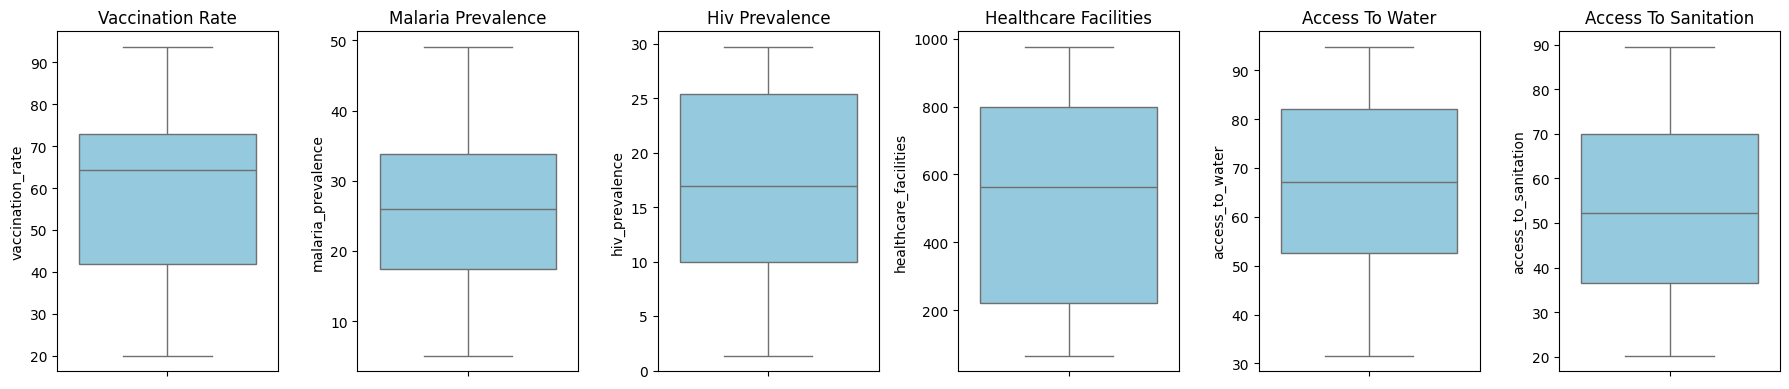

In [11]:
NUMERIC_COLS = [
    'vaccination_rate',
    'malaria_prevalence',
    'hiv_prevalence',
    'healthcare_facilities',
    'access_to_water',
    'access_to_sanitation'
]

plt.figure(figsize=(18, 4))
for i, col in enumerate(NUMERIC_COLS, 1):
    plt.subplot(1, len(NUMERIC_COLS), i)
    sns.boxplot(y=df_raw[col], color='skyblue')
    plt.title(col.replace('_', ' ').title())
plt.tight_layout()
plt.show()


In [12]:
# Final preview
df_raw.info()
df_raw.describe()

# Save cleaned data
df_clean = df_raw.copy()
df_clean.to_csv('african_healthcare_data_cleaned.csv', index=False)
print("Saved cleaned data as african_healthcare_data_cleaned.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                54 non-null     object 
 1   region                 54 non-null     object 
 2   vaccination_rate       54 non-null     float64
 3   malaria_prevalence     54 non-null     float64
 4   hiv_prevalence         54 non-null     float64
 5   healthcare_facilities  54 non-null     int64  
 6   access_to_water        54 non-null     float64
 7   access_to_sanitation   54 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.5+ KB
Saved cleaned data as african_healthcare_data_cleaned.csv


### Section2: Exploratory Data Analysis (EDA)

In [13]:
df_cleaned = pd.read_csv("african_healthcare_data_cleaned.csv")

In [14]:
df_cleaned.rename(columns={
    'Country': 'country',
    'Region': 'region',
    'Vaccination_Rate': 'vaccination_rate',
    'Malaria_Prevalence': 'malaria_prevalence',
    'HIV_Prevalence': 'hiv_prevalence',
    'Healthcare_Facilities': 'healthcare_facilities',
    'Access_to_Water': 'access_to_water',
    'Access_to_Sanitation': 'access_to_sanitation'
}, inplace=True)


## Summary Statistics
#### Calculate mean, median, min, max, and standard deviation for key indicators.
##### This will display a table of central tendency and dispersion metrics for each indicator.

In [15]:
# Define key indicators for summary statistics
key_indicators = [
    'malaria_prevalence',
    'hiv_prevalence',
    'healthcare_facilities',
    'access_to_water',
    'access_to_sanitation',
    'vaccination_rate'
]


# Compute summary statistics
summary_stats = df_cleaned[key_indicators].describe().T
summary_stats['median'] = df_cleaned[key_indicators].median()
summary_stats = summary_stats[['mean', 'median', 'min', 'max', 'std']]
display(summary_stats)


,mean,median,min,max,std
malaria_prevalence,26.058803,26.007571,5.063224,49.082396,12.285467
hiv_prevalence,17.204512,16.946055,1.353391,29.721633,8.971196
healthcare_facilities,513.833333,562.000000,66.000000,976.000000,292.412267
access_to_water,66.415278,67.119655,31.555577,94.811452,17.783274
access_to_sanitation,53.902081,52.320717,20.223906,89.479342,19.571024
vaccination_rate,57.929297,64.369694,20.024306,93.681152,20.977881


In [16]:
print(df_cleaned.columns.tolist())


['country', 'region', 'vaccination_rate', 'malaria_prevalence', 'hiv_prevalence', 'healthcare_facilities', 'access_to_water', 'access_to_sanitation']


##  Visualizations Distribution of Key Indicators using Histograms and Boxplots

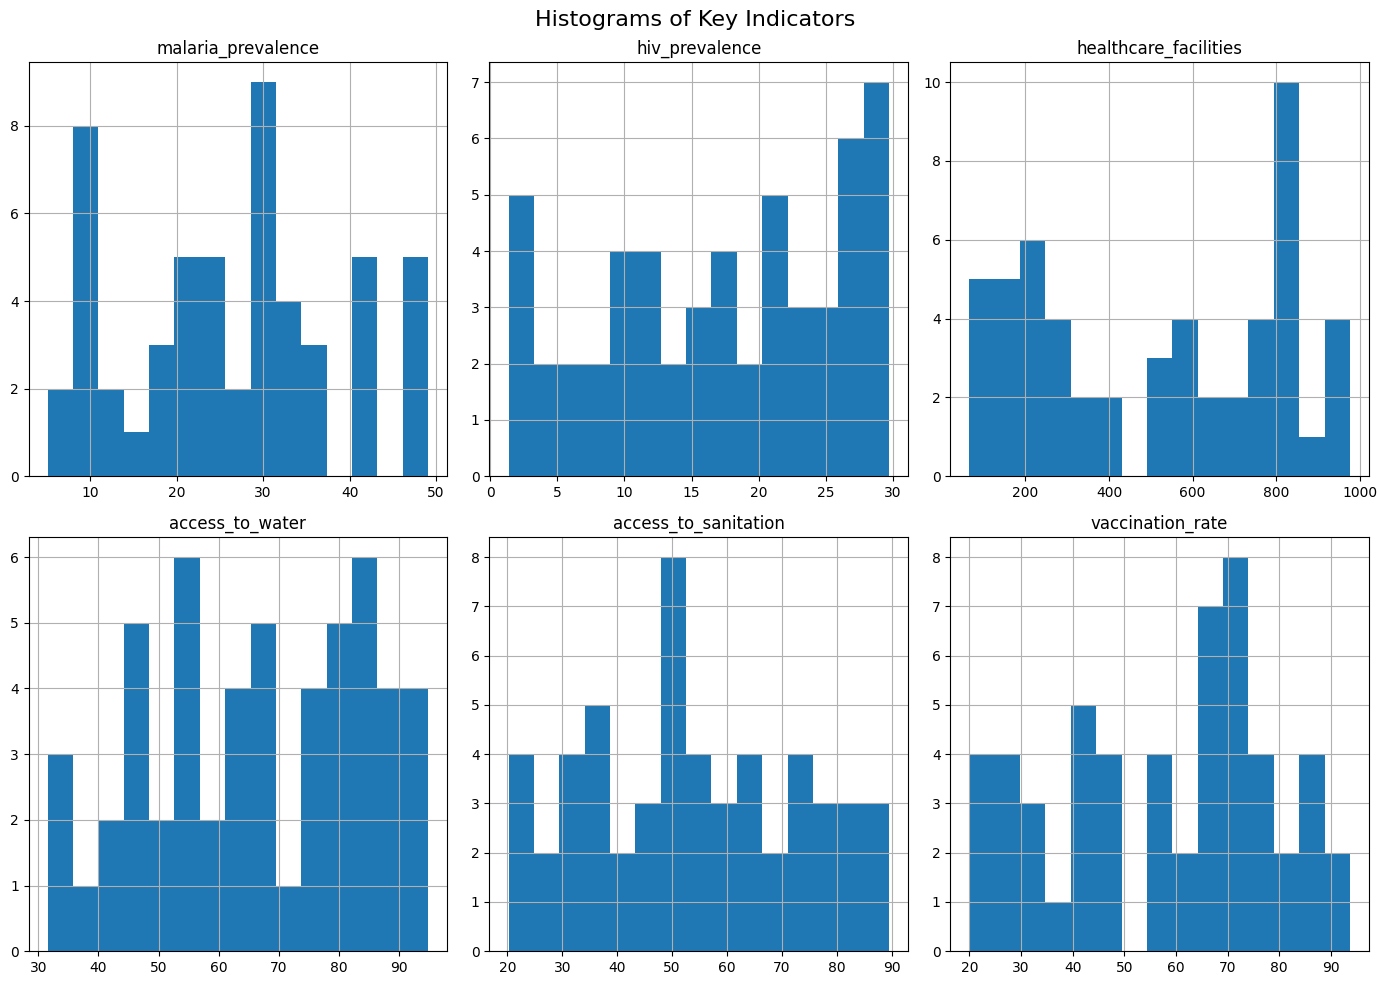

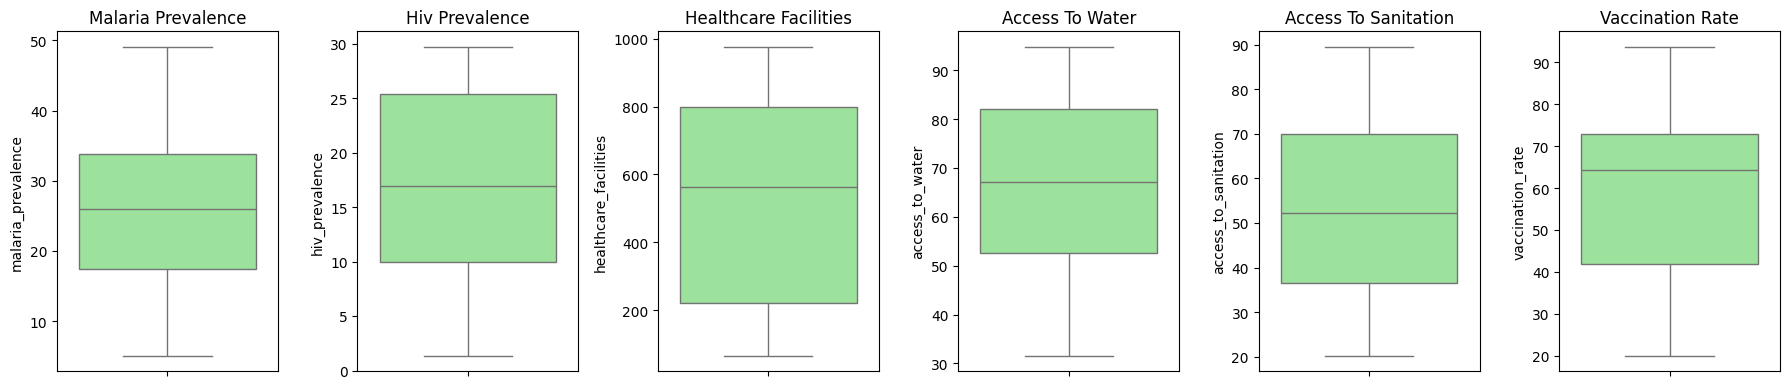

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns




# Histograms
df_cleaned[key_indicators].hist(figsize=(14, 10), bins=15, layout=(2,3))
plt.suptitle('Histograms of Key Indicators', fontsize=16)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(18, 4))
for i, col in enumerate(key_indicators, 1):
    plt.subplot(1, len(key_indicators), i)
    sns.boxplot(y=df_cleaned[col], color='lightgreen')
    plt.title(col.replace('_', ' ').title())
plt.tight_layout()
plt.show()


## Scatter Plots: Key Healthcare Relationships
#### The following scatter plots visualize key relationships between healthcare resources and disease indicators across African countries.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10656\4230332317.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')


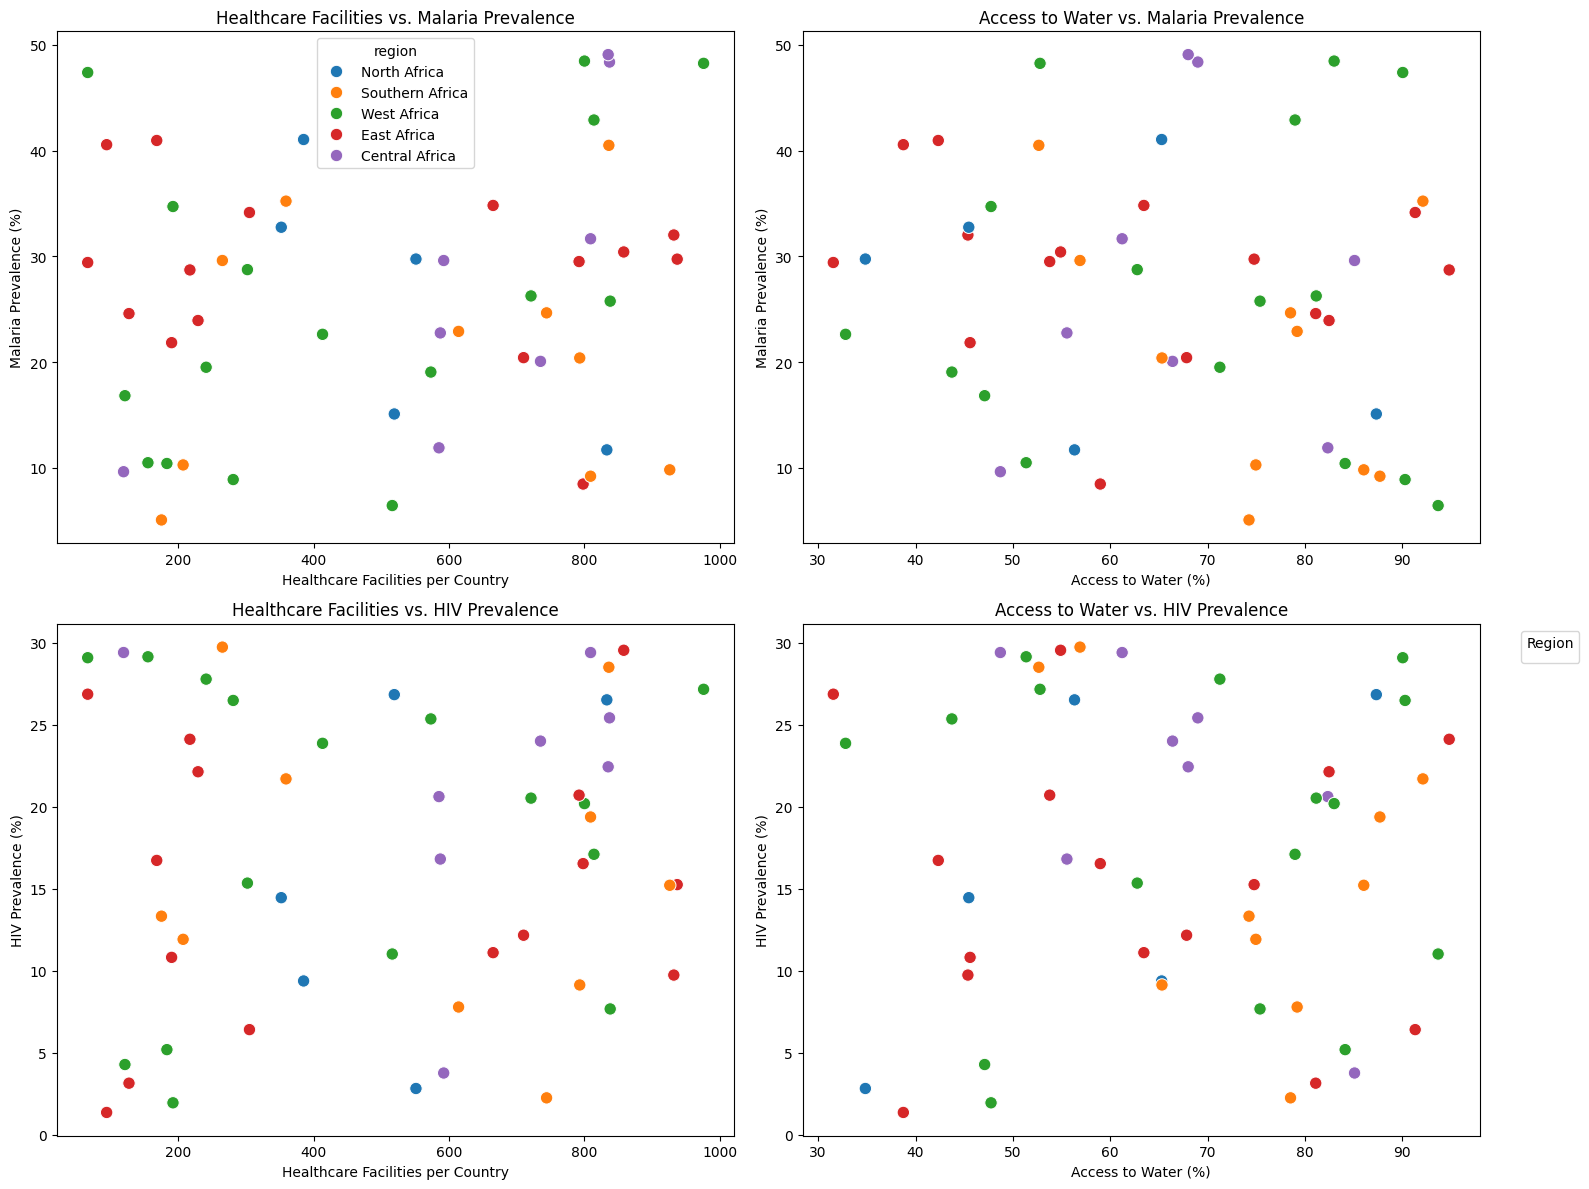

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 1. Healthcare Facilities vs. Malaria Prevalence
sns.scatterplot(
    data=df_cleaned, x='healthcare_facilities', y='malaria_prevalence',
    hue='region', s=80, ax=axs[0,0]
)
axs[0,0].set_title('Healthcare Facilities vs. Malaria Prevalence')
axs[0,0].set_xlabel('Healthcare Facilities per Country')
axs[0,0].set_ylabel('Malaria Prevalence (%)')

# 2. Access to Water vs. Malaria Prevalence
sns.scatterplot(
    data=df_cleaned, x='access_to_water', y='malaria_prevalence',
    hue='region', s=80, legend=False, ax=axs[0,1]
)
axs[0,1].set_title('Access to Water vs. Malaria Prevalence')
axs[0,1].set_xlabel('Access to Water (%)')
axs[0,1].set_ylabel('Malaria Prevalence (%)')

# 3. Healthcare Facilities vs. HIV Prevalence
sns.scatterplot(
    data=df_cleaned, x='healthcare_facilities', y='hiv_prevalence',
    hue='region', s=80, legend=False, ax=axs[1,0]
)
axs[1,0].set_title('Healthcare Facilities vs. HIV Prevalence')
axs[1,0].set_xlabel('Healthcare Facilities per Country')
axs[1,0].set_ylabel('HIV Prevalence (%)')

# 4. Access to Water vs. HIV Prevalence
sns.scatterplot(
    data=df_cleaned, x='access_to_water', y='hiv_prevalence',
    hue='region', s=80, legend=False, ax=axs[1,1]
)
axs[1,1].set_title('Access to Water vs. HIV Prevalence')
axs[1,1].set_xlabel('Access to Water (%)')
axs[1,1].set_ylabel('HIV Prevalence (%)')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


 ### Correlation Matrix

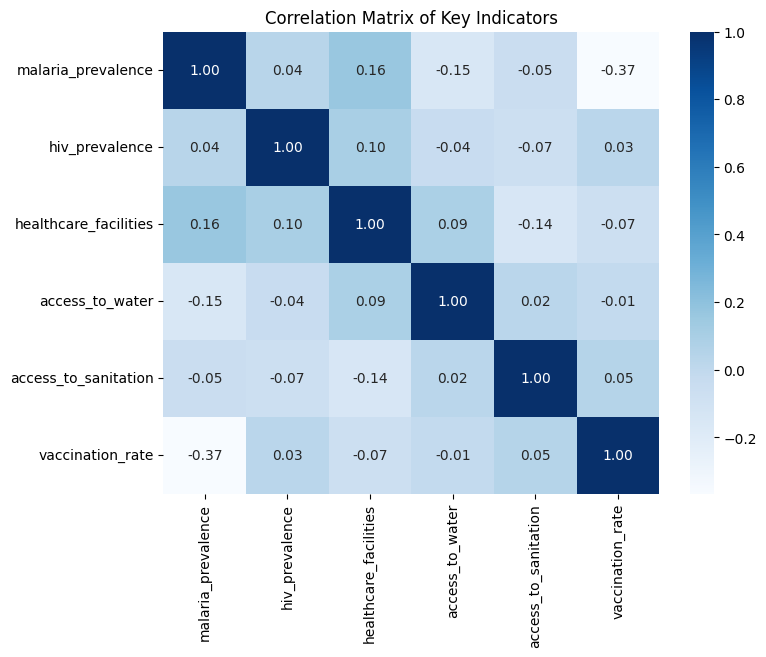

In [19]:
corr = df_cleaned[key_indicators].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix of Key Indicators')
plt.show()


#### Country Comparisons Bar Chart: Top 10 Countries by Malaria Prevalence

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10656\2158637068.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_malaria, x='malaria_prevalence', y='country', palette='Reds_d')


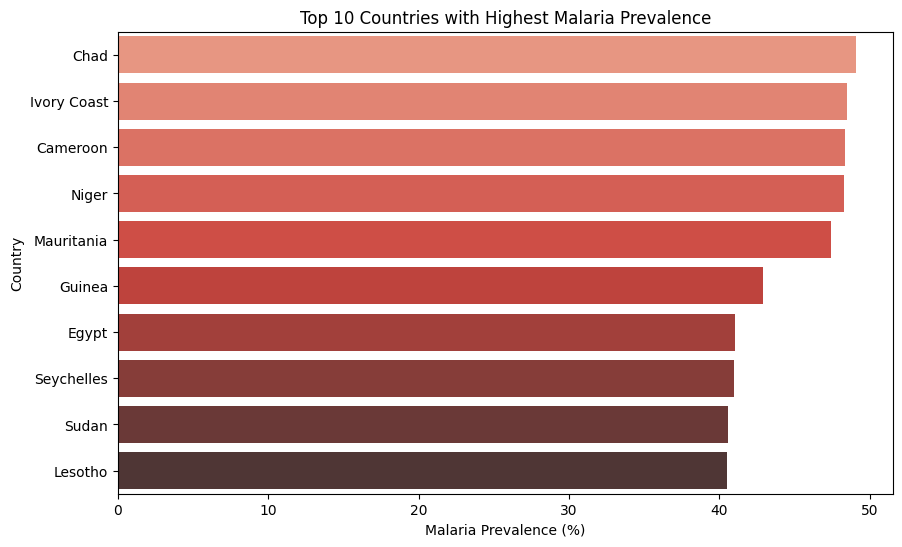

In [20]:
top_malaria = df_cleaned[['country', 'malaria_prevalence']].sort_values(by='malaria_prevalence', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top_malaria, x='malaria_prevalence', y='country', palette='Reds_d')
plt.title('Top 10 Countries with Highest Malaria Prevalence')
plt.xlabel('Malaria Prevalence (%)')
plt.ylabel('Country')
plt.show()


### Heatmap: Country vs. Key Health Metrics

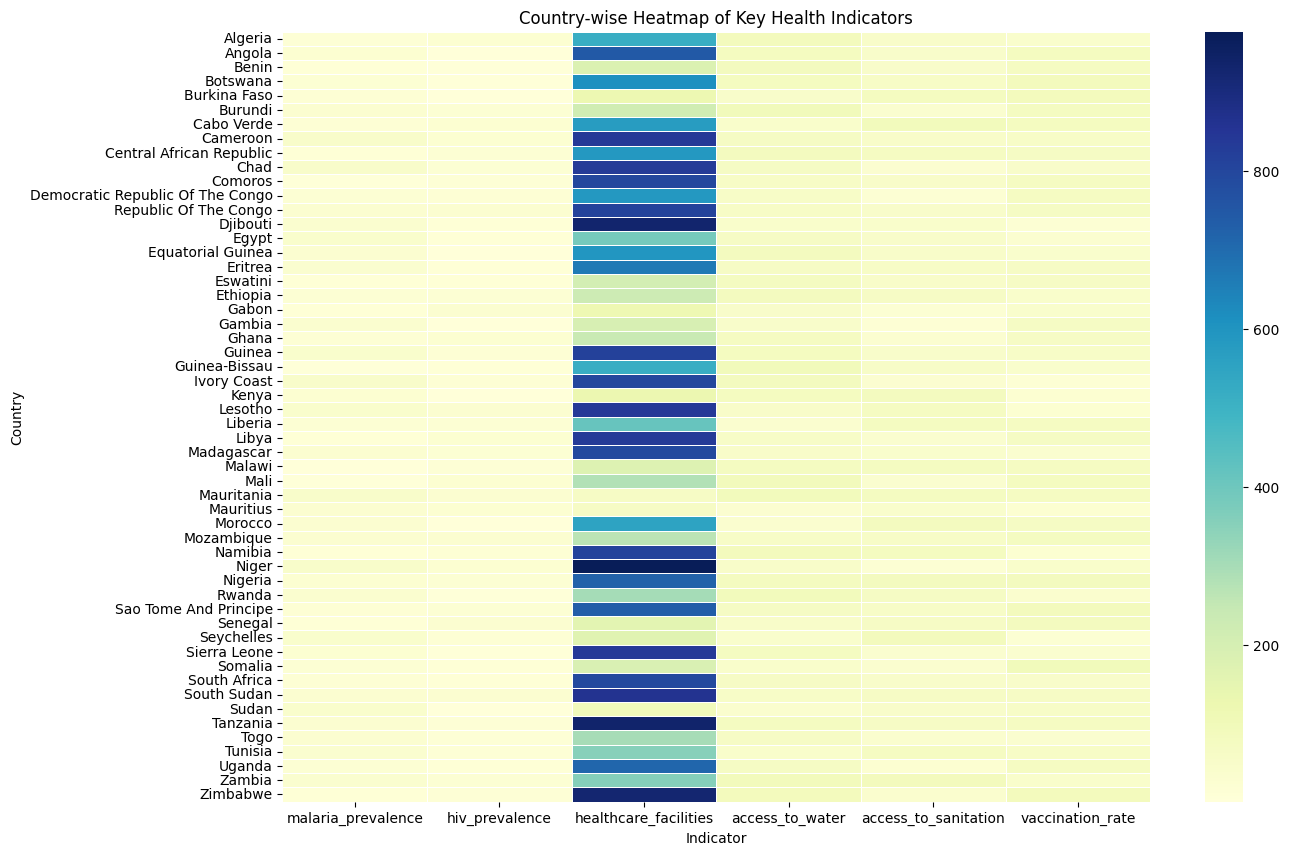

In [21]:
heatmap_data = df_cleaned.set_index('country')[key_indicators].copy()
plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title('Country-wise Heatmap of Key Health Indicators')
plt.ylabel('Country')
plt.xlabel('Indicator')
plt.show()


## Section 3: Dashboard Development

In [22]:
import dash
from dash import Dash, html, dcc, Input, Output, callback
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def generate_choropleth(data, indicator, map_title):
    """Generate choropleth map for Africa showing selected health indicator"""
    try:
        # Check if required columns exist
        if 'iso_alpha' not in data.columns:
            # Try common alternatives for country codes
            if 'iso_code' in data.columns:
                data = data.rename(columns={'iso_code': 'iso_alpha'})
            elif 'country_code' in data.columns:
                data = data.rename(columns={'country_code': 'iso_alpha'})
            else:
                # Create a simple country mapping if no ISO codes
                country_iso_map = {
                    'Nigeria': 'NGA', 'Kenya': 'KEN', 'South Africa': 'ZAF',
                    'Ghana': 'GHA', 'Egypt': 'EGY', 'Morocco': 'MAR',
                    'Ethiopia': 'ETH', 'Algeria': 'DZA', 'Uganda': 'UGA',
                    'Tanzania': 'TZA', 'Cameroon': 'CMR', 'Madagascar': 'MDG',
                    'Mali': 'MLI', 'Burkina Faso': 'BFA', 'Niger': 'NER',
                    'Senegal': 'SEN', 'Chad': 'TCD', 'Guinea': 'GIN',
                    'Rwanda': 'RWA', 'Benin': 'BEN', 'Tunisia': 'TUN',
                    'Burundi': 'BDI', 'Togo': 'TGO', 'Sierra Leone': 'SLE',
                    'Libya': 'LBY', 'Liberia': 'LBR', 'Mauritania': 'MRT',
                    'Namibia': 'NAM', 'Botswana': 'BWA', 'Gambia': 'GMB',
                    'Gabon': 'GAB', 'Lesotho': 'LSO', 'Guinea-Bissau': 'GNB',
                    'Equatorial Guinea': 'GNQ', 'Mauritius': 'MUS',
                    'Eswatini': 'SWZ', 'Djibouti': 'DJI', 'Comoros': 'COM',
                    'Cape Verde': 'CPV', 'Sao Tome and Principe': 'STP',
                    'Seychelles': 'SYC', 'Central African Republic': 'CAF',
                    'Democratic Republic of Congo': 'COD', 'Republic of Congo': 'COG',
                    'Ivory Coast': 'CIV', 'Cote d\'Ivoire': 'CIV',
                    'Zambia': 'ZMB', 'Zimbabwe': 'ZWE', 'Malawi': 'MWI',
                    'Mozambique': 'MOZ', 'Angola': 'AGO', 'Sudan': 'SDN',
                    'South Sudan': 'SSD', 'Somalia': 'SOM', 'Eritrea': 'ERI'
                }
                data['iso_alpha'] = data['country'].map(country_iso_map)
        
        fig = px.choropleth(
            data_frame=data,
            locations='iso_alpha',
            color=indicator,
            hover_name='country',
            hover_data={'region': True, indicator: ':.2f'} if 'region' in data.columns else {indicator: ':.2f'},
            color_continuous_scale='Viridis',
            labels={indicator: indicator.replace('_', ' ').title()},
            scope='africa',
            title=map_title,
            projection='natural earth'
        )
        fig.update_geos(
            showcountries=True, 
            fitbounds="locations",
            showcoastlines=True,
            countrycolor="white"
        )
        fig.update_layout(
            margin={"r":0,"t":50,"l":0,"b":0},
            height=500,
            font=dict(color="white"),
            paper_bgcolor="#23272a",
            plot_bgcolor="#23272a"
        )
        return fig
    except Exception as e:
        # Fallback: create a simple bar chart if map fails
        fig = px.bar(
            data.head(10), 
            x='country', 
            y=indicator,
            title=f"{map_title} (Bar Chart - Map Error)",
            color_discrete_sequence=['#f1c40f']
        )
        fig.update_layout(
            paper_bgcolor="#23272a",
            plot_bgcolor="#23272a",
            font=dict(color="white"),
            xaxis_tickangle=-45
        )
        return fig

# Load your cleaned dataset
try:
    df = pd.read_csv('african_healthcare_data_cleaned.csv')
    print("Dataset loaded successfully!")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Shape: {df.shape}")
    
    # Check for required columns and create them if missing
    required_columns = ['country', 'malaria_prevalence', 'hiv_prevalence', 
                       'healthcare_facilities', 'access_to_water', 
                       'access_to_sanitation', 'vaccination_rate']
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        # Create dummy data for missing columns
        for col in missing_columns:
            df[col] = 0
    
    # Ensure region column exists
    if 'region' not in df.columns:
        # Create basic regions based on country names
        north_africa = ['Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Sudan']
        west_africa = ['Nigeria', 'Ghana', 'Mali', 'Burkina Faso', 'Niger', 'Senegal', 'Guinea', 'Benin', 'Togo', 'Sierra Leone', 'Liberia', 'Mauritania', 'Gambia', 'Guinea-Bissau', 'Cape Verde', 'Ivory Coast', 'Cote d\'Ivoire']
        east_africa = ['Kenya', 'Ethiopia', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi', 'Somalia', 'Eritrea', 'Djibouti', 'South Sudan', 'Madagascar', 'Mauritius', 'Seychelles', 'Comoros']
        central_africa = ['Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of Congo', 'Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']
        southern_africa = ['South Africa', 'Namibia', 'Botswana', 'Zambia', 'Zimbabwe', 'Malawi', 'Mozambique', 'Angola', 'Lesotho', 'Eswatini']
        
        def assign_region(country):
            if country in north_africa:
                return 'North Africa'
            elif country in west_africa:
                return 'West Africa'
            elif country in east_africa:
                return 'East Africa'
            elif country in central_africa:
                return 'Central Africa'
            elif country in southern_africa:
                return 'Southern Africa'
            else:
                return 'Other'
        
        df['region'] = df['country'].apply(assign_region)
    
except FileNotFoundError:
    print("CSV file not found. Creating sample data...")
    # Create sample data for demonstration
    import numpy as np
    np.random.seed(42)
    
    countries = ['Nigeria', 'Kenya', 'South Africa', 'Ghana', 'Egypt', 'Morocco', 
                'Ethiopia', 'Algeria', 'Uganda', 'Tanzania', 'Cameroon', 'Madagascar',
                'Mali', 'Burkina Faso', 'Niger', 'Senegal', 'Chad', 'Guinea', 'Rwanda', 'Benin']
    
    df = pd.DataFrame({
        'country': countries,
        'malaria_prevalence': np.random.uniform(5, 45, len(countries)),
        'hiv_prevalence': np.random.uniform(0.1, 15, len(countries)),
        'healthcare_facilities': np.random.uniform(0.5, 8, len(countries)),
        'access_to_water': np.random.uniform(30, 95, len(countries)),
        'access_to_sanitation': np.random.uniform(20, 85, len(countries)),
        'vaccination_rate': np.random.uniform(40, 95, len(countries)),
        'region': ['West Africa', 'East Africa', 'Southern Africa', 'West Africa', 'North Africa',
                  'North Africa', 'East Africa', 'North Africa', 'East Africa', 'East Africa',
                  'Central Africa', 'East Africa', 'West Africa', 'West Africa', 'West Africa',
                  'West Africa', 'Central Africa', 'West Africa', 'East Africa', 'West Africa']
    })
    
    # Add ISO alpha codes
    country_iso_map = {
        'Nigeria': 'NGA', 'Kenya': 'KEN', 'South Africa': 'ZAF', 'Ghana': 'GHA',
        'Egypt': 'EGY', 'Morocco': 'MAR', 'Ethiopia': 'ETH', 'Algeria': 'DZA',
        'Uganda': 'UGA', 'Tanzania': 'TZA', 'Cameroon': 'CMR', 'Madagascar': 'MDG',
        'Mali': 'MLI', 'Burkina Faso': 'BFA', 'Niger': 'NER', 'Senegal': 'SEN',
        'Chad': 'TCD', 'Guinea': 'GIN', 'Rwanda': 'RWA', 'Benin': 'BEN'
    }
    df['iso_alpha'] = df['country'].map(country_iso_map)
    
    print("Sample data created successfully!")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Shape: {df.shape}")

except Exception as e:
    print(f"Error loading data: {e}")
    # Create minimal fallback data
    df = pd.DataFrame({
        'country': ['Nigeria', 'Kenya', 'South Africa'],
        'malaria_prevalence': [25, 15, 5],
        'hiv_prevalence': [2, 5, 18],
        'healthcare_facilities': [2, 3, 6],
        'access_to_water': [70, 60, 85],
        'access_to_sanitation': [40, 30, 75],
        'vaccination_rate': [60, 70, 80],
        'region': ['West Africa', 'East Africa', 'Southern Africa'],
        'iso_alpha': ['NGA', 'KEN', 'ZAF']
    })

# App initialization with Bootstrap theme
app = Dash(__name__, external_stylesheets=[dbc.themes.CYBORG])

# Header section
header = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("African Health Dashboard", 
                   className="display-4 text-warning mb-2"),
            html.P("Interactive visualization of healthcare indicators across African countries",
                   className="lead text-light")
        ], width=12)
    ])
], fluid=True, className="bg-dark py-3 mb-4")

# Control panel
controls = dbc.Card([
    dbc.CardBody([
        html.H4("Dashboard Controls", className="text-warning mb-3"),
        
        # Primary indicator selector
        html.Label("Select Health Indicator:", className="text-light mb-2"),
        dcc.Dropdown(
            id='primary-indicator',
            options=[
                {'label': 'Malaria Prevalence (%)', 'value': 'malaria_prevalence'},
                {'label': 'HIV Prevalence (%)', 'value': 'hiv_prevalence'},
                {'label': 'Healthcare Facilities per 1000', 'value': 'healthcare_facilities'},
                {'label': 'Access to Clean Water (%)', 'value': 'access_to_water'},
                {'label': 'Access to Sanitation (%)', 'value': 'access_to_sanitation'},
                {'label': 'Vaccination Coverage (%)', 'value': 'vaccination_rate'}
            ],
            value='malaria_prevalence',
            className="mb-3"
        ),
        
        # Region filter
        html.Label("Filter by Region:", className="text-light mb-2"),
        dcc.Dropdown(
            id='region-filter',
            options=[{'label': 'All Regions', 'value': 'all'}] + 
                   [{'label': region, 'value': region} for region in sorted(df['region'].unique())],
            value='all',
            className="mb-3"
        ),
        
        # Country multi-select
        html.Label("Select Countries (optional):", className="text-light mb-2"),
        dcc.Dropdown(
            id='country-filter',
            options=[{'label': country, 'value': country} for country in sorted(df['country'].unique())],
            multi=True,
            placeholder='Select specific countries...',
            className="mb-3"
        ),
        
        # Comparison indicator
        html.Label("Compare with Second Indicator:", className="text-light mb-2"),
        dcc.Dropdown(
            id='comparison-indicator',
            options=[
                {'label': 'None', 'value': 'none'},
                {'label': 'Malaria Prevalence (%)', 'value': 'malaria_prevalence'},
                {'label': 'HIV Prevalence (%)', 'value': 'hiv_prevalence'},
                {'label': 'Healthcare Facilities', 'value': 'healthcare_facilities'},
                {'label': 'Access to Water (%)', 'value': 'access_to_water'},
                {'label': 'Access to Sanitation (%)', 'value': 'access_to_sanitation'},
                {'label': 'Vaccination Rate (%)', 'value': 'vaccination_rate'}
            ],
            value='none',
            className="mb-3"
        )
    ])
], className="h-100", style={"backgroundColor": "#2c3e50"})

# Main content layout
content = dbc.Container([
    # Top row - Main map and summary stats
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='africa-map', config={'displayModeBar': False})
        ], width=8),
        dbc.Col([
            dbc.Card([
                dbc.CardBody([
                    html.H4(id='summary-title', className="text-warning"),
                    html.H2(id='summary-value', className="text-light mb-2"),
                    html.P(id='summary-description', className="text-muted"),
                    html.Hr(),
                    html.Div(id='regional-stats')
                ])
            ], className="h-100", style={"backgroundColor": "#34495e"})
        ], width=4)
    ], className="mb-4"),
    
    # Second row - Comparative analysis
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='regional-comparison', config={'displayModeBar': False})
        ], width=6),
        dbc.Col([
            dcc.Graph(id='scatter-analysis', config={'displayModeBar': False})
        ], width=6)
    ], className="mb-4"),
    
    # Third row - Detailed analytics
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='top-countries-bar', config={'displayModeBar': False})
        ], width=6),
        dbc.Col([
            dcc.Graph(id='correlation-heatmap', config={'displayModeBar': False})
        ], width=6)
    ])
], fluid=True)

# Sidebar layout
sidebar = dbc.Col([controls], width=3, className="pe-3")
main_content = dbc.Col([content], width=9)

# Complete app layout
app.layout = html.Div([
    header,
    dbc.Container([
        dbc.Row([sidebar, main_content])
    ], fluid=True)
], style={"backgroundColor": "#181c20", "minHeight": "100vh"})

@app.callback(
    [Output('africa-map', 'figure'),
     Output('summary-title', 'children'),
     Output('summary-value', 'children'),
     Output('summary-description', 'children'),
     Output('regional-stats', 'children'),
     Output('regional-comparison', 'figure'),
     Output('scatter-analysis', 'figure'),
     Output('top-countries-bar', 'figure'),
     Output('correlation-heatmap', 'figure')],
    [Input('primary-indicator', 'value'),
     Input('region-filter', 'value'),
     Input('country-filter', 'value'),
     Input('comparison-indicator', 'value')]
)
def update_dashboard(primary_indicator, region_filter, selected_countries, comparison_indicator):
    try:
        # Filter data based on selections
        dff = df.copy()
        
        if region_filter != 'all' and 'region' in dff.columns:
            dff = dff[dff['region'] == region_filter]
        
        if selected_countries:
            dff = dff[dff['country'].isin(selected_countries)]
        
        # Ensure we have data
        if dff.empty:
            dff = df.copy()
        
        # 1. Main Africa Map
        indicator_title = primary_indicator.replace('_', ' ').title()
        map_fig = generate_choropleth(dff, primary_indicator, f'{indicator_title} Across Africa')
        
        # 2. Summary statistics
        summary_title = f"Average {indicator_title}"
        summary_value = f"{dff[primary_indicator].mean():.2f}"
        summary_description = f"Based on {len(dff)} countries"
        
        # Regional breakdown
        regional_stats = []
        if 'region' in dff.columns:
            regional_breakdown = dff.groupby('region')[primary_indicator].agg(['mean', 'count']).round(2)
            for region, stats in regional_breakdown.iterrows():
                regional_stats.append(
                    html.Div([
                        html.Strong(f"{region}: ", className="text-warning"),
                        html.Span(f"{stats['mean']:.2f} ({stats['count']} countries)", className="text-light")
                    ], className="mb-1")
                )
        else:
            regional_stats = [html.Div("Regional data not available", className="text-muted")]
        
        # 3. Regional comparison box plot
        if 'region' in dff.columns and len(dff['region'].unique()) > 1:
            regional_fig = px.box(
                dff, x='region', y=primary_indicator, color='region',
                title=f'{indicator_title} Distribution by Region',
                color_discrete_sequence=px.colors.qualitative.Set3
            )
        else:
            regional_fig = px.histogram(
                dff, x=primary_indicator, nbins=10,
                title=f'{indicator_title} Distribution',
                color_discrete_sequence=['#f1c40f']
            )
        
        regional_fig.update_layout(
            paper_bgcolor="#23272a", plot_bgcolor="#23272a",
            font=dict(color="white"), showlegend=False
        )
        
        # 4. Scatter analysis
        if comparison_indicator != 'none' and comparison_indicator in dff.columns:
            scatter_fig = px.scatter(
                dff, x=primary_indicator, y=comparison_indicator,
                color='region' if 'region' in dff.columns else None,
                size='healthcare_facilities' if 'healthcare_facilities' in dff.columns else None,
                hover_name='country',
                title=f'{indicator_title} vs {comparison_indicator.replace("_", " ").title()}',
                color_discrete_sequence=px.colors.qualitative.Pastel
            )
        else:
            # Default scatter with healthcare facilities
            y_col = 'healthcare_facilities' if 'healthcare_facilities' in dff.columns else primary_indicator
            scatter_fig = px.scatter(
                dff, x=primary_indicator, y=y_col,
                color='region' if 'region' in dff.columns else None,
                hover_name='country',
                title=f'{indicator_title} vs {y_col.replace("_", " ").title()}',
                color_discrete_sequence=px.colors.qualitative.Pastel
            )
        
        scatter_fig.update_layout(
            paper_bgcolor="#23272a", plot_bgcolor="#23272a",
            font=dict(color="white")
        )
        
        # 5. Top countries bar chart
        top_countries = dff.nlargest(min(10, len(dff)), primary_indicator)
        bar_fig = px.bar(
            top_countries, x='country', y=primary_indicator,
            color='region' if 'region' in dff.columns else None,
            title=f'Top Countries: {indicator_title}',
            color_discrete_sequence=px.colors.qualitative.G10
        )
        bar_fig.update_layout(
            paper_bgcolor="#23272a", plot_bgcolor="#23272a",
            font=dict(color="white"), xaxis_tickangle=-45
        )
        
        # 6. Correlation heatmap
        numeric_cols = [col for col in ['malaria_prevalence', 'hiv_prevalence', 'healthcare_facilities', 
                                       'access_to_water', 'access_to_sanitation', 'vaccination_rate'] 
                       if col in dff.columns]
        
        if len(numeric_cols) > 1:
            corr_matrix = dff[numeric_cols].corr()
            heatmap_fig = px.imshow(
                corr_matrix, text_auto=".2f",
                color_continuous_scale='RdYlBu_r',
                title="Health Indicators Correlation Matrix",
                aspect="auto"
            )
        else:
            # Fallback: simple bar chart
            heatmap_fig = px.bar(
                x=numeric_cols, y=[1]*len(numeric_cols),
                title="Available Indicators",
                color_discrete_sequence=['#f1c40f']
            )
        
        heatmap_fig.update_layout(
            paper_bgcolor="#23272a", plot_bgcolor="#23272a",
            font=dict(color="white")
        )
        
        return (map_fig, summary_title, summary_value, summary_description, 
                regional_stats, regional_fig, scatter_fig, bar_fig, heatmap_fig)
        
    except Exception as e:
        print(f"Dashboard update error: {e}")
        # Return empty/default figures in case of error
        empty_fig = px.bar(x=[1], y=[1], title="Error loading data")
        empty_fig.update_layout(paper_bgcolor="#23272a", plot_bgcolor="#23272a", font=dict(color="white"))
        
        return (empty_fig, "Error", "N/A", "Data loading failed", 
                [html.Div("Error loading regional stats", className="text-danger")],
                empty_fig, empty_fig, empty_fig, empty_fig)

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8052)

Dataset loaded successfully!
Columns: ['country', 'region', 'vaccination_rate', 'malaria_prevalence', 'hiv_prevalence', 'healthcare_facilities', 'access_to_water', 'access_to_sanitation']
Shape: (54, 8)
